# Stock Market Prediction using Time-series and Daily News Analysis
## k-Nearest Neighbours
### Preprocessing and Modeling

In [19]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from math import sqrt
import datetime as dt

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,6

pd.set_option('mode.chained_assignment', 'raise') # Raise an exception, warn, or no action if trying to use chained assignment

In [3]:
# Read the combines stock index CSV data file from the data directory
dataset = pd.read_csv('data/comb_data_final.csv',index_col='Date',parse_dates=True)

In [4]:
# Create a separate dataset
new_data = dataset.reset_index()[['Date', 'Adj Close']]
new_data.head()

,Date,Adj Close
0,2008-08-08,11734.320312
1,2008-08-11,11782.349609
2,2008-08-12,11642.469727
3,2008-08-13,11532.959961
4,2008-08-14,11615.929688


In [5]:
new_data.shape

(1989, 2)

In [5]:
# Set the threshold two years before the last date (at the beginning of 7th year)
threshold = new_data['Date'].max() - pd.DateOffset(years=2) 
# Create Train and Test datasets
X_train = new_data[new_data['Date'] <= threshold]['Date']
X_test = new_data[new_data['Date'] > threshold]['Date']
y_train = new_data[new_data['Date'] <= threshold]['Adj Close']
y_test = new_data[new_data['Date'] > threshold]['Adj Close']
X_train.shape, X_test.shape

((1484,), (505,))

## Multiple Linear Regression (w/ Feature Engineering)

In [6]:
new_data1 = new_data.copy()
new_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1989 non-null   datetime64[ns]
 1   Adj Close  1989 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.2 KB


In [7]:
# Add new features made from Date column
new_data1['Year'] = new_data1['Date'].dt.year
new_data1['Month'] = new_data1['Date'].dt.month
new_data1['Week'] = new_data1['Date'].dt.isocalendar().week
new_data1['Day'] = new_data1['Date'].dt.day
new_data1['Dayofweek'] = new_data1['Date'].dt.dayofweek
new_data1['Dayofyear'] = new_data1['Date'].dt.dayofyear
new_data1['Is_month_start'] = new_data1['Date'].dt.is_month_start.astype('int')
new_data1['Is_month_end'] = new_data1['Date'].dt.is_month_end.astype('int')
new_data1['Is_quarter_start'] = new_data1['Date'].dt.is_quarter_start.astype('int')
new_data1['Is_quarter_end'] = new_data1['Date'].dt.is_quarter_end.astype('int')
new_data1['Is_year_start'] = new_data1['Date'].dt.is_year_start.astype('int')
new_data1['Is_year_end'] = new_data1['Date'].dt.is_year_end.astype('int')

In [8]:
new_data1['mon_fri'] = 0
for i in range(0,len(new_data1)):
    if (new_data1['Dayofweek'][i] == 0 or new_data1['Dayofweek'][i] == 4):
        new_data1.loc[i, 'mon_fri'] = 1

In [9]:
new_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1989 non-null   datetime64[ns]
 1   Adj Close         1989 non-null   float64       
 2   Year              1989 non-null   int64         
 3   Month             1989 non-null   int64         
 4   Week              1989 non-null   UInt32        
 5   Day               1989 non-null   int64         
 6   Dayofweek         1989 non-null   int64         
 7   Dayofyear         1989 non-null   int64         
 8   Is_month_start    1989 non-null   int32         
 9   Is_month_end      1989 non-null   int32         
 10  Is_quarter_start  1989 non-null   int32         
 11  Is_quarter_end    1989 non-null   int32         
 12  Is_year_start     1989 non-null   int32         
 13  Is_year_end       1989 non-null   int32         
 14  mon_fri           1989 n

In [12]:
# Create Train and Test datasets
train = new_data1[:1484]
test = new_data1[1484:]

X_train = train.drop('Adj Close', axis=1)
X_test = test.drop('Adj Close', axis=1)
y_train = train['Adj Close']
y_test = test['Adj Close']

In [13]:
X_train['Date']=X_train['Date'].map(dt.datetime.toordinal)
X_test['Date']=X_test['Date'].map(dt.datetime.toordinal)

### Model

In [14]:
#scaling data
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(X_train,y_train)
preds = model.predict(X_test)

In [15]:
#make predictions and find the rmse
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

5548.741496541511

In [ ]:
test['Predictions'] = preds

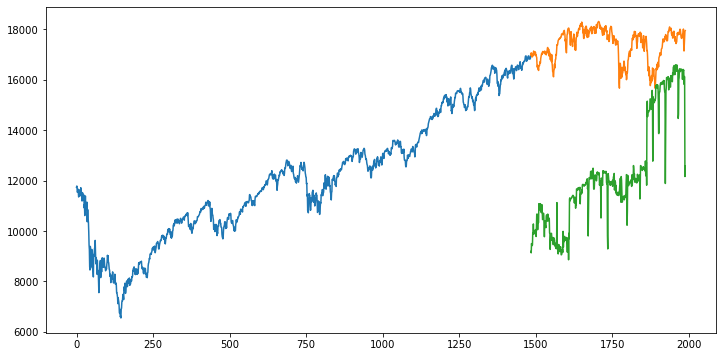

In [17]:
#plot
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])

In [ ]:
# Do I need to transform back to the dates in the above plot?

## Support Vector Regression
### Preprocessing and Modeling

In [23]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1) 
svr_rbf.fit(X_train, y_train)

#make predictions and find the rmse
preds = svr_rbf.predict(X_test)
preds[:10]

array([8126.2504203 , 8134.32248266, 8189.44223017, 8141.99781001,
       8087.04695676, 8105.26360197, 8136.25075026, 8185.7083274 ,
       8152.33513713, 8107.51552682])

In [24]:
#make predictions and find the rmse
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

5865.747228947665

In [22]:
# Optional!
svm_confidence = svr_rbf.score(X_test, y_test)
print("svm R^2: ", svm_confidence)

svm R^2:  -92.59414926768721


In [ ]:
test['Predictions'] = preds

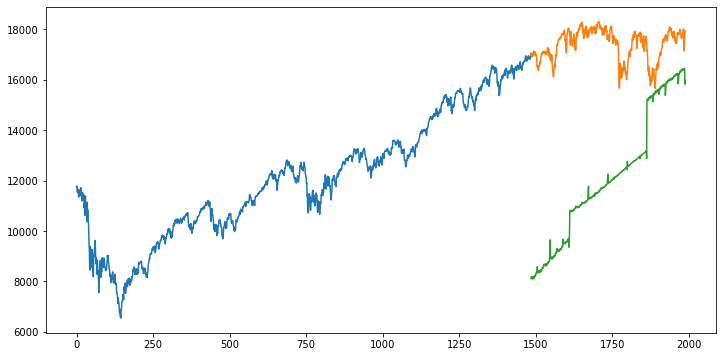

In [26]:
#plot
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])